In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from ae_model import Autoencoder
from sklearn.decomposition import PCA

The autoencoder model is pre-trained from previous project: [interactive_denoiser](https://github.com/ShlomiRex/interactive_denoiser)

Its simple autoencoder with 3 CNN layers (and the decoder is the reverse of the encoder).

In [2]:
# Load the pretrained model
model = Autoencoder(128)
model.load_state_dict(torch.load("ae_model.pth"))

# Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

C:\Users\Shlomi\AppData\Local\Temp\ipykernel_7856\3359886163.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_model.pth"))


Autoencoder(
  (enc_conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu1): ReLU()
  (enc_conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu2): ReLU()
  (enc_conv3): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1))
  (enc_linear): Linear(in_features=128, out_features=128, bias=True)
  (dec_linear): Linear(in_features=128, out_features=128, bias=True)
  (dec_conv1): ConvTranspose2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
  (dec_relu1): ReLU()
  (dec_conv2): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_relu2): ReLU()
  (dec_conv3): ConvTranspose2d(512, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_tanh): Tanh()
)

In [3]:
dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 64
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
len(dataset)

10000

# View latent space of VAE

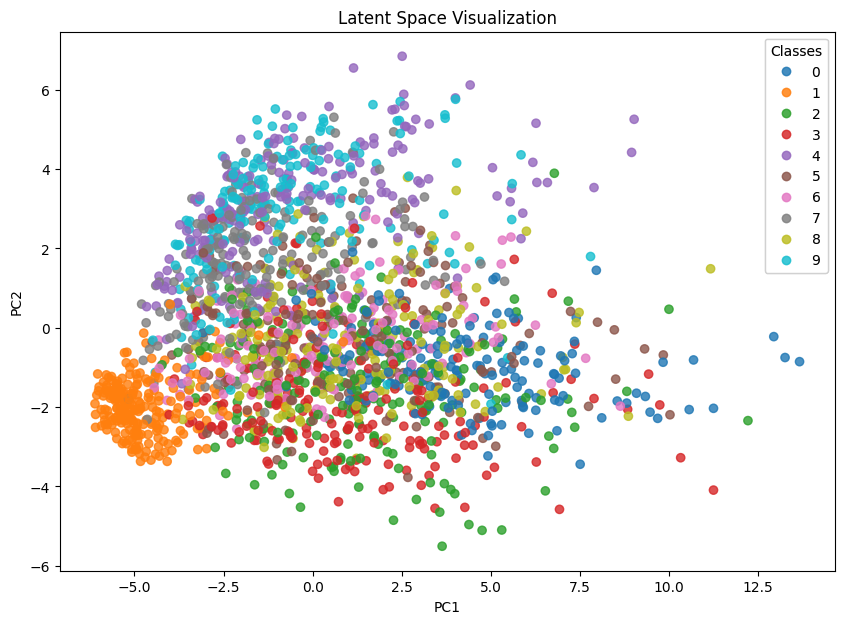

In [4]:
# Extract latent vectors from a subset of the test set
def extract_latent_vectors(loader, num_samples=500):
    latent_vectors = []
    labels = []
    count = 0

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            latent = model.encode(images).view(images.size(0), -1)  # Flatten latent space

            latent_vectors.append(latent.cpu())
            labels.append(targets)
            count += images.size(0)

            if count >= num_samples:  # Stop after collecting enough samples
                break

    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    labels = torch.cat(labels, dim=0)[:num_samples]
    return latent_vectors.numpy(), labels.numpy()

# Visualize the latent space
def plot_latent_space(latent_2d, labels):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    scatter = ax.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.8)
    ax.set_title('Latent Space Visualization')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

    # Add legend
    legend = ax.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
    ax.add_artist(legend)

    plt.show()


num_samples = 2_000
latent_vectors, labels = extract_latent_vectors(dataset_loader, num_samples)

# Reduce dimensionality to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)
plot_latent_space(latent_2d, labels)

The PCA analysis tells us the model is not learning the latent space well.

# Sample random latent vectors

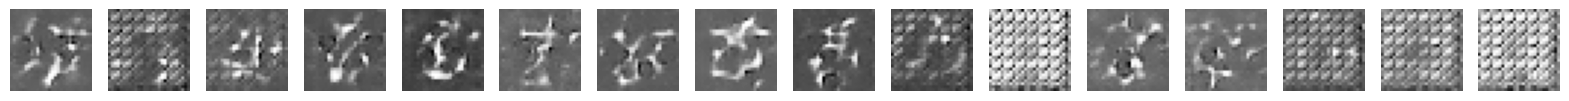

In [5]:
# Sample random latent vectors and decode them
n_samples = 16
latent_samples = torch.randn(n_samples, 128).to(device)
reconstructed_samples = model.decode(latent_samples).cpu()

# Visualize the reconstructed samples
fig, axes = plt.subplots(1, n_samples, figsize=(20, 2))

for i in range(n_samples):
    axes[i].imshow(reconstructed_samples[i].view(28, 28).detach().numpy(), cmap='gray')
    axes[i].axis('off')

plt.show()

# This is not VAE. Every image is mapped to fixed latent vector. We can't interpolate between latent vectors. This is where Variational Autoencoder comes into play.

We can now build the VAE in the next notebook called `vae.ipynb`.

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import torch.nn as nn
from einops import rearrange
from torchsummary import summary
import torch.optim as optim

<img src="img.jpg" alt="Drawing" style="width: 800px;"/>

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.__setup_encoder()
        self.__setup_decoder()
    
    def __setup_encoder(self):
        self.enc_conv1 = nn.Conv2d(1, 512, kernel_size=3, stride=2, padding=1) # Output: 512 x 14 x 14
        self.enc_relu1 = nn.ReLU()
        self.enc_conv2 = nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1) # Output: 256 x 7 x 7
        self.enc_relu2 = nn.ReLU()
        self.enc_conv3 = nn.Conv2d(256, 128, kernel_size=7) # Output: 128 x 1 x 1
        self.enc_linear = nn.Linear(128, self.latent_dim) # Output: 1 x latent_dim

        self.fc_mu = nn.Linear(self.hidden_dim, self.latent_dim)  # Mean vector
        self.fc_logvar = nn.Linear(self.hidden_dim, self.latent_dim)  # Log-variance vector

    def __setup_decoder(self):
        self.dec_linear = nn.Linear(self.latent_dim, 128) # Output: 1 x 128
        self.dec_conv1 = nn.ConvTranspose2d(128, 256, kernel_size=7) # Output: 512 x 7 x 7
        self.dec_relu1 = nn.ReLU()
        self.dec_conv2 = nn.ConvTranspose2d(256, 512, kernel_size=3, stride=2, padding=1, output_padding=1) # Output: 512 x 14 x 14
        self.dec_relu2 = nn.ReLU()
        self.dec_conv3 = nn.ConvTranspose2d(512, 1, kernel_size=3, stride=2, padding=1, output_padding=1) # Output: 1 x 28 x 28
        self.dec_tanh = nn.Tanh()
    
    def encode(self, x):
        assert x.shape[-3:] == (1, 28, 28)
        assert x.min() >= -1 and x.max() <= 1
        
        # Normalize the tensor to be in the range [0, 1]
        x = torch.clamp(x, 0, 1)

        x = self.enc_conv1(x)
        x = self.enc_relu1(x)
        x = self.enc_conv2(x)
        x = self.enc_relu2(x)
        x = self.enc_conv3(x)
        x = rearrange(x, 'b c h w -> b (c h w)') # Remove h, w dimensions which are 1
        x = self.enc_linear(x)

        mean = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        # Here we don't return x, we return mean and log_var, this is different to AE
        return mean, log_var
    
    def decode(self, latent):
        assert latent.shape[-1] == self.latent_dim
        x = self.dec_linear(latent)
        x = rearrange(x, 'b c -> b c 1 1') # Add h, w dimensions which are 1, prepare to add spatial information
        x = self.dec_conv1(x)
        x = self.dec_relu1(x)
        x = self.dec_conv2(x)
        x = self.dec_relu2(x)
        x = self.dec_conv3(x)
        x = self.dec_tanh(x)
        return x
    
    def sample(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std)
        z = z * std + mean
        return z

    def forward(self, x):
        assert x.shape[-3:] == (1, 28, 28)
        # Encode - instead of latent vector we get mean and log_var (look at image!)
        mean, log_var = self.encode(x)

        # Here is the magic of VAE
        z = self.sample(mean, log_var)
        
        # Decode
        x_reconstructed = self.decode(z)
        return mean, log_var, x_reconstructed

In [8]:
vae = VariationalAutoencoder(128, 128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 14, 14]           5,120
              ReLU-2          [-1, 512, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]       1,179,904
              ReLU-4            [-1, 256, 7, 7]               0
            Conv2d-5            [-1, 128, 1, 1]       1,605,760
            Linear-6                  [-1, 128]          16,512
            Linear-7                  [-1, 128]          16,512
            Linear-8                  [-1, 128]          16,512
            Linear-9                  [-1, 128]          16,512
  ConvTranspose2d-10            [-1, 256, 7, 7]       1,605,888
             ReLU-11            [-1, 256, 7, 7]               0
  ConvTranspose2d-12          [-1, 512, 14, 14]       1,180,160
             ReLU-13          [-1, 512, 14, 14]               0
  ConvTranspose2d-14            [-1, 1,

The VAE model has similar parameter count as the base autoencoder model.

The base AE model has 5,614,465 parameters.

This model has 5,647,489 parameters, a 0.5% increase in parameters.

# Without training, see the VAE reconstruction

In [9]:
del model # We don't need the AE model anymore
model = None
model = vae
criterion = nn.MSELoss() # We can use ELBO loss also, but because the base model is trained with MSE, we will use it

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
# Transformations: Normalize and convert to tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoader
batch_size = 64 # Too much batch. We need to learn slowly

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

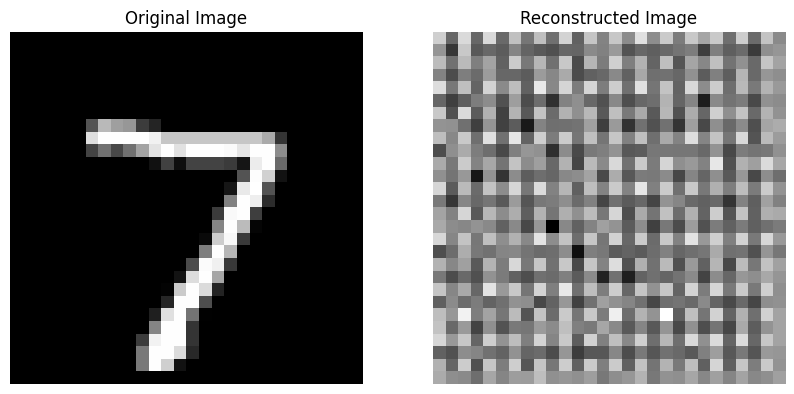

In [11]:
# Select a single image from the test dataset
single_image, _ = test_dataset[0]
single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Pass the image through the encoder
with torch.no_grad():
    mean, log_var = model.encode(single_image)
    latent_vector = model.sample(mean, log_var)
    reconstructed = model.decode(latent_vector)  # Pass the latent vector through the decoder
# Plot the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(single_image.cpu().view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


# Train the model on MNIST dataset

In [12]:
from tqdm import tqdm
import cv2
import numpy as np

In [13]:
# Training loop
num_epochs = 5

loss_history = []
kl_divergence_history = []
recon_loss_history = []

gamma = 0.1 # Weight for the reconstruction term in the loss function

for epoch in range(num_epochs):
    model.train()

    # Use tqdm for progress tracking
    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as t:
        for images, _ in t:
            images = images.to(device)

            optimizer.zero_grad() # Zero gradients before performing a backward pass

            # Forward pass
            mean, log_var, outputs = model(images)

            # Save the image and reconstructed image
            # cv2.imwrite(f"in.png", ((images[0] + 1)/2 * 255).view(28, 28).cpu().numpy())
            # cv2.imwrite(f"out.png", ((outputs[0] + 1)/2 * 255).view(28, 28).detach().cpu().numpy())

            # Backward pass and optimization
            # KL divergence is the regularization term
            kl_loss = torch.mean(0.5 * torch.sum(torch.exp(log_var) + mean**2 - 1 - log_var, dim=1))
            recon_loss = criterion(outputs, images)
            loss = recon_loss * gamma + kl_loss

            recon_loss_history.append(recon_loss.item())
            kl_divergence_history.append(kl_loss.item())
            loss_history.append(loss.item())

            # Propogate the loss backward
            loss.backward() # Compute gradients (of KL + recon losses)
            optimizer.step() # Adjust weights of the model

            # # Update tqdm description with current loss
            # t.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {np.mean(recon_loss_history).item():.4f}, KL Loss: {np.mean(kl_divergence_history).item():.4f}")

Epoch [1/5]: 100%|██████████| 938/938 [00:18<00:00, 51.01it/s]


Epoch [1/5], Recon Loss: 0.2755, KL Loss: 0.0690


Epoch [2/5]: 100%|██████████| 938/938 [00:17<00:00, 52.66it/s]


Epoch [2/5], Recon Loss: 0.2728, KL Loss: 0.0345


Epoch [3/5]: 100%|██████████| 938/938 [00:19<00:00, 47.69it/s]


Epoch [3/5], Recon Loss: 0.2718, KL Loss: 0.0230


Epoch [4/5]: 100%|██████████| 938/938 [00:19<00:00, 48.68it/s]


Epoch [4/5], Recon Loss: 0.2713, KL Loss: 0.0173


Epoch [5/5]: 100%|██████████| 938/938 [00:19<00:00, 48.71it/s]

Epoch [5/5], Recon Loss: 0.2709, KL Loss: 0.0138


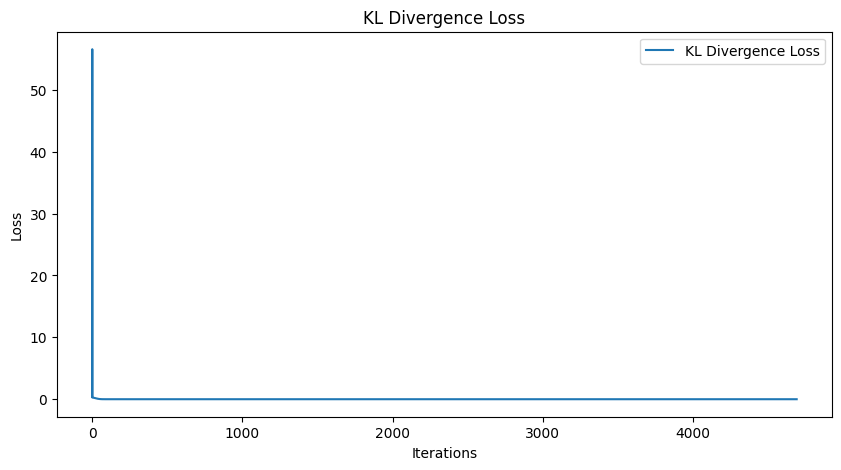

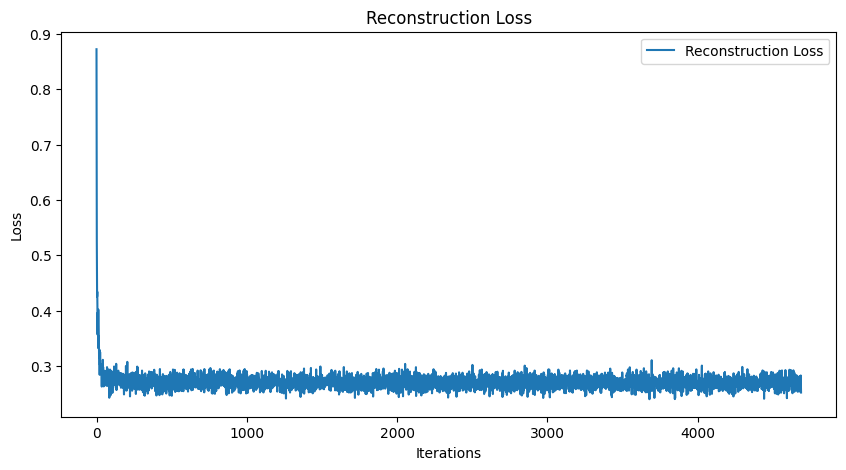

In [14]:
# Plot the log of the loss history, KL divergence in one graph and reconstruction loss in another.

plt.figure(figsize=(10, 5))
plt.plot(kl_divergence_history, label='KL Divergence Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('KL Divergence Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.show()


# Visualize latent vector reconstruction

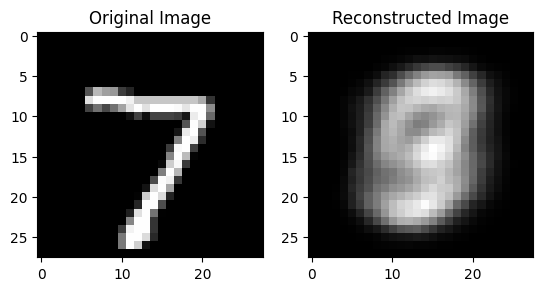

In [15]:
# Function to visualize results
def visualize_results(model, test_loader):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _, _, reconstructed = model(images)
            break

    # Plot original and reconstructed images
    images = images.cpu()
    reconstructed = reconstructed.cpu()
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(images[0].squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(reconstructed[0].squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed Image')
    plt.show()

visualize_results(model, test_loader)


# Check if the model can denoise without explicitly training on noise data

In [16]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    """
    Adds Gaussian noise to a batch of images.
    
    Parameters:
    images (torch.Tensor): Batch of images.
    mean (float): Mean of the Gaussian noise.
    std (float): Standard deviation of the Gaussian noise.
    
    Returns:
    torch.Tensor: Noisy images.
    """
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

def add_salt_and_pepper_noise(images, salt_prob=0.1, pepper_prob=0.1):
    """
    Adds salt and pepper noise to a batch of images.
    
    Parameters:
    images (torch.Tensor): Batch of images.
    salt_prob (float): Probability of adding salt noise.
    pepper_prob (float): Probability of adding pepper noise.
    
    Returns:
    torch.Tensor: Noisy images.
    """
    noisy_images = images.clone()
    salt_mask = torch.rand_like(images) < salt_prob
    pepper_mask = torch.rand_like(images) < pepper_prob
    noisy_images[salt_mask] = 1.0
    noisy_images[pepper_mask] = 0.0
    return noisy_images

def sample_value(mean, std):
    value = torch.randn(1) * std + mean
    return value.clamp(0, 1).item()

TypeError: Invalid shape (8, 28, 28) for image data

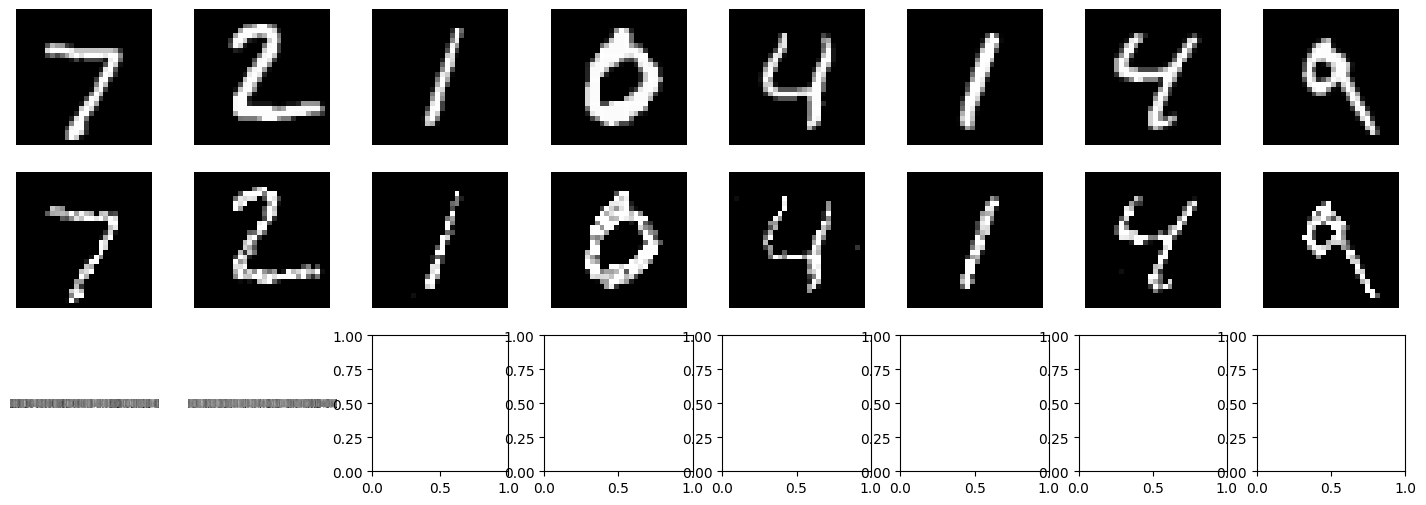

In [17]:
# Take 8 images from the test set, add noise and reconstruct
images, _ = next(iter(test_loader))
images = images[:8]

# Add Gaussian noise
noisy_images = add_gaussian_noise(images, std=sample_value(0.6, 0.2))
noisy_images = noisy_images.to(device)

# Reconstruct the images
model.eval()
with torch.no_grad():
    reconstructed = model(noisy_images)
    # Plot original, noisy and reconstructed images
    fig, axes = plt.subplots(3, 8, figsize=(18, 6))
    for images, row in zip([images, noisy_images, reconstructed], axes):
        for img, ax in zip(images, row):
            img = img.to('cpu')
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

# Sample from latent space

In [ ]:
# Sample random latent vectors from a standard normal distribution
n_samples = 16

mean = torch.zeros(vae.latent_dim)
std = torch.ones(vae.latent_dim)


latent_samples = model.sample(mean, std).to(device)

# Decode the latent vectors to generate images
vae.eval()
with torch.no_grad():
    generated_images = vae.decode(latent_samples).cpu()

# Visualize the generated images
fig, axes = plt.subplots(1, n_samples, figsize=(20, 2))
for i in range(n_samples):
    axes[i].imshow(generated_images[i].view(28, 28), cmap='gray')
    axes[i].axis('off')

plt.show()